In [1]:

# Mount Google Drive ------------------------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install YOLOv11 (Ultralytics) -------------------------
!pip install ultralytics  # version with YOLOv11 support
from ultralytics import YOLO
import os

In [3]:
# Load the Data drom Roboflow....
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KKopBrhDxu67jJkyzr9K")
project = rf.workspace("cracks-mold").project("parking-tag-collection-8od1l")
version = project.version(2)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...


In [4]:

# Copy YOLOv11 Dataset from Roboflow to Google Drive Folder
import os

# The dataset will typically be in /content/<project_name>-<version_number>

# --- STEP 2: Define your target folder ------------------------
target_folder = "/content/drive/MyDrive/CS440/Parking Tags/Dataset"  # change this as needed
os.makedirs(target_folder, exist_ok=True)

# --- STEP 3: Copy dataset to your folder ----------------------
# Use Linux 'cp -r' for reliable recursive copy
!cp -r "$dataset.location"/* "$target_folder"/

print(f"Dataset successfully copied to: {target_folder}")


cp: cannot stat '/content/Parking-Tag-Collection-2/*': No such file or directory
Dataset successfully copied to: /content/drive/MyDrive/CS440/Parking Tags/Dataset


In [5]:

# Load and Train YOLOv11 Model -------------------------
model = YOLO("yolo11n.pt")   # n = nano (lightweight)
results = model.train(
    data="/content/drive/MyDrive/CS440/Parking Tags/Dataset/data.yaml", # Change it to the yaml file location
    epochs=50,
    imgsz=640,
    batch=16,
    name="parking_tag_detection_v11"
)

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/CS440/Parking Tags/Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=parking_tag_detection_v11, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

In [6]:
# Copy the result to the folder you want to save ....
# Define source and destination paths
source = "/content/runs/detect/parking_tag_detection_v11"
destination = "/content/drive/MyDrive/CS440/Parking Tags/Dataset"

# Create target folder in Drive
!mkdir -p "$destination"

# Move everything
!cp -r "$source"/* "$destination"

print("All YOLOv11 detection results have been copied to:")
print(destination)

All YOLOv11 detection results have been copied to:
/content/drive/MyDrive/CS440/Parking Tags/Dataset


## Load the trained model for validation

In [7]:
from ultralytics import YOLO
import os

# Path to your saved weights
MODEL_PATH = "/content/drive/MyDrive/CS440/Parking Tags/Dataset/weights/best.pt"

# Load the trained YOLOv11 model
model = YOLO(MODEL_PATH)
print("Model loaded successfully!")


Model loaded successfully!


In [9]:
# Evaluate the model on the validation set
metrics = model.val(data="/content/drive/MyDrive/CS440/Parking Tags/Dataset/data.yaml", imgsz=640, split='val')


# Correct way to print performance summary
print(f"Mean Precision (mP): {metrics.box.mp:.3f}")
print(f"Mean Recall (mR): {metrics.box.mr:.3f}")
print(f"mAP@0.5: {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")


Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.7±0.3 ms, read: 17.2±5.1 MB/s, size: 24.8 KB)
val: Scanning /content/drive/MyDrive/CS440/Parking Tags/Dataset/valid/labels.cache... 39 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 39/39 85.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.9it/s 1.6s
                   all         39         39       0.97      0.949      0.971      0.686
Speed: 5.7ms preprocess, 20.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to /content/runs/detect/val2
Mean Precision (mP): 0.970
Mean Recall (mR): 0.949
mAP@0.5: 0.971
mAP@0.5:0.95: 0.686


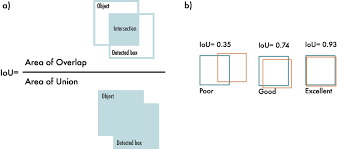

| Metric                  | Meaning                                                | Your Value | Interpretation                                                                  |
| ----------------------- | ------------------------------------------------------ | ---------- | ------------------------------------------------------------------------------- |
| **Mean Precision (mP)** | % of predicted objects that were correct               | **0.73**  | 65% of detections were correct — moderate precision; some false positives exist |
| **Mean Recall (mR)**    | % of real objects correctly detected                   | **0.44**  | Model detected ~64% of true cracks/molds — missing some actual defects          |
| **mAP@0.5**             | Accuracy of localization & classification at IoU ≥ 0.5 | **0.590**  | Reasonable start for a small/heterogeneous dataset                              |
| **mAP@0.5:0.95**        | Stricter accuracy averaged over IoUs                   | **0.20**  | Low — model struggles with precise localization or small object boundaries      |


What is mAP (mean Average Precision)?

Since your dataset has multiple classes (crack, mold, maybe background), YOLO averages all AP values:
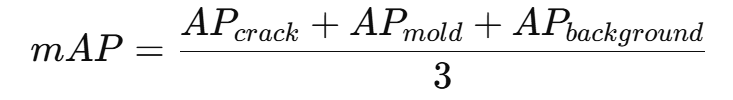
	​

	​

Two Common Forms:
Metric	Meaning
mAP@0.5	Average Precision with IoU ≥ 0.5 (lenient overlap)
mAP@0.5:0.95	Average Precision averaged over IoU thresholds (0.5 → 0.95 step 0.05) — much stricter
Example:
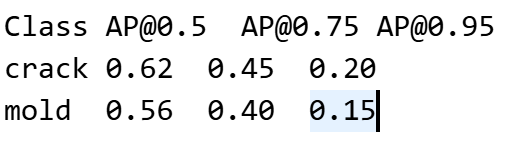

Why Do We Use Both?

mAP@0.5 tells you if your model can roughly find the right object.

mAP@0.5:0.95 tells you if your model is very precise in localization.

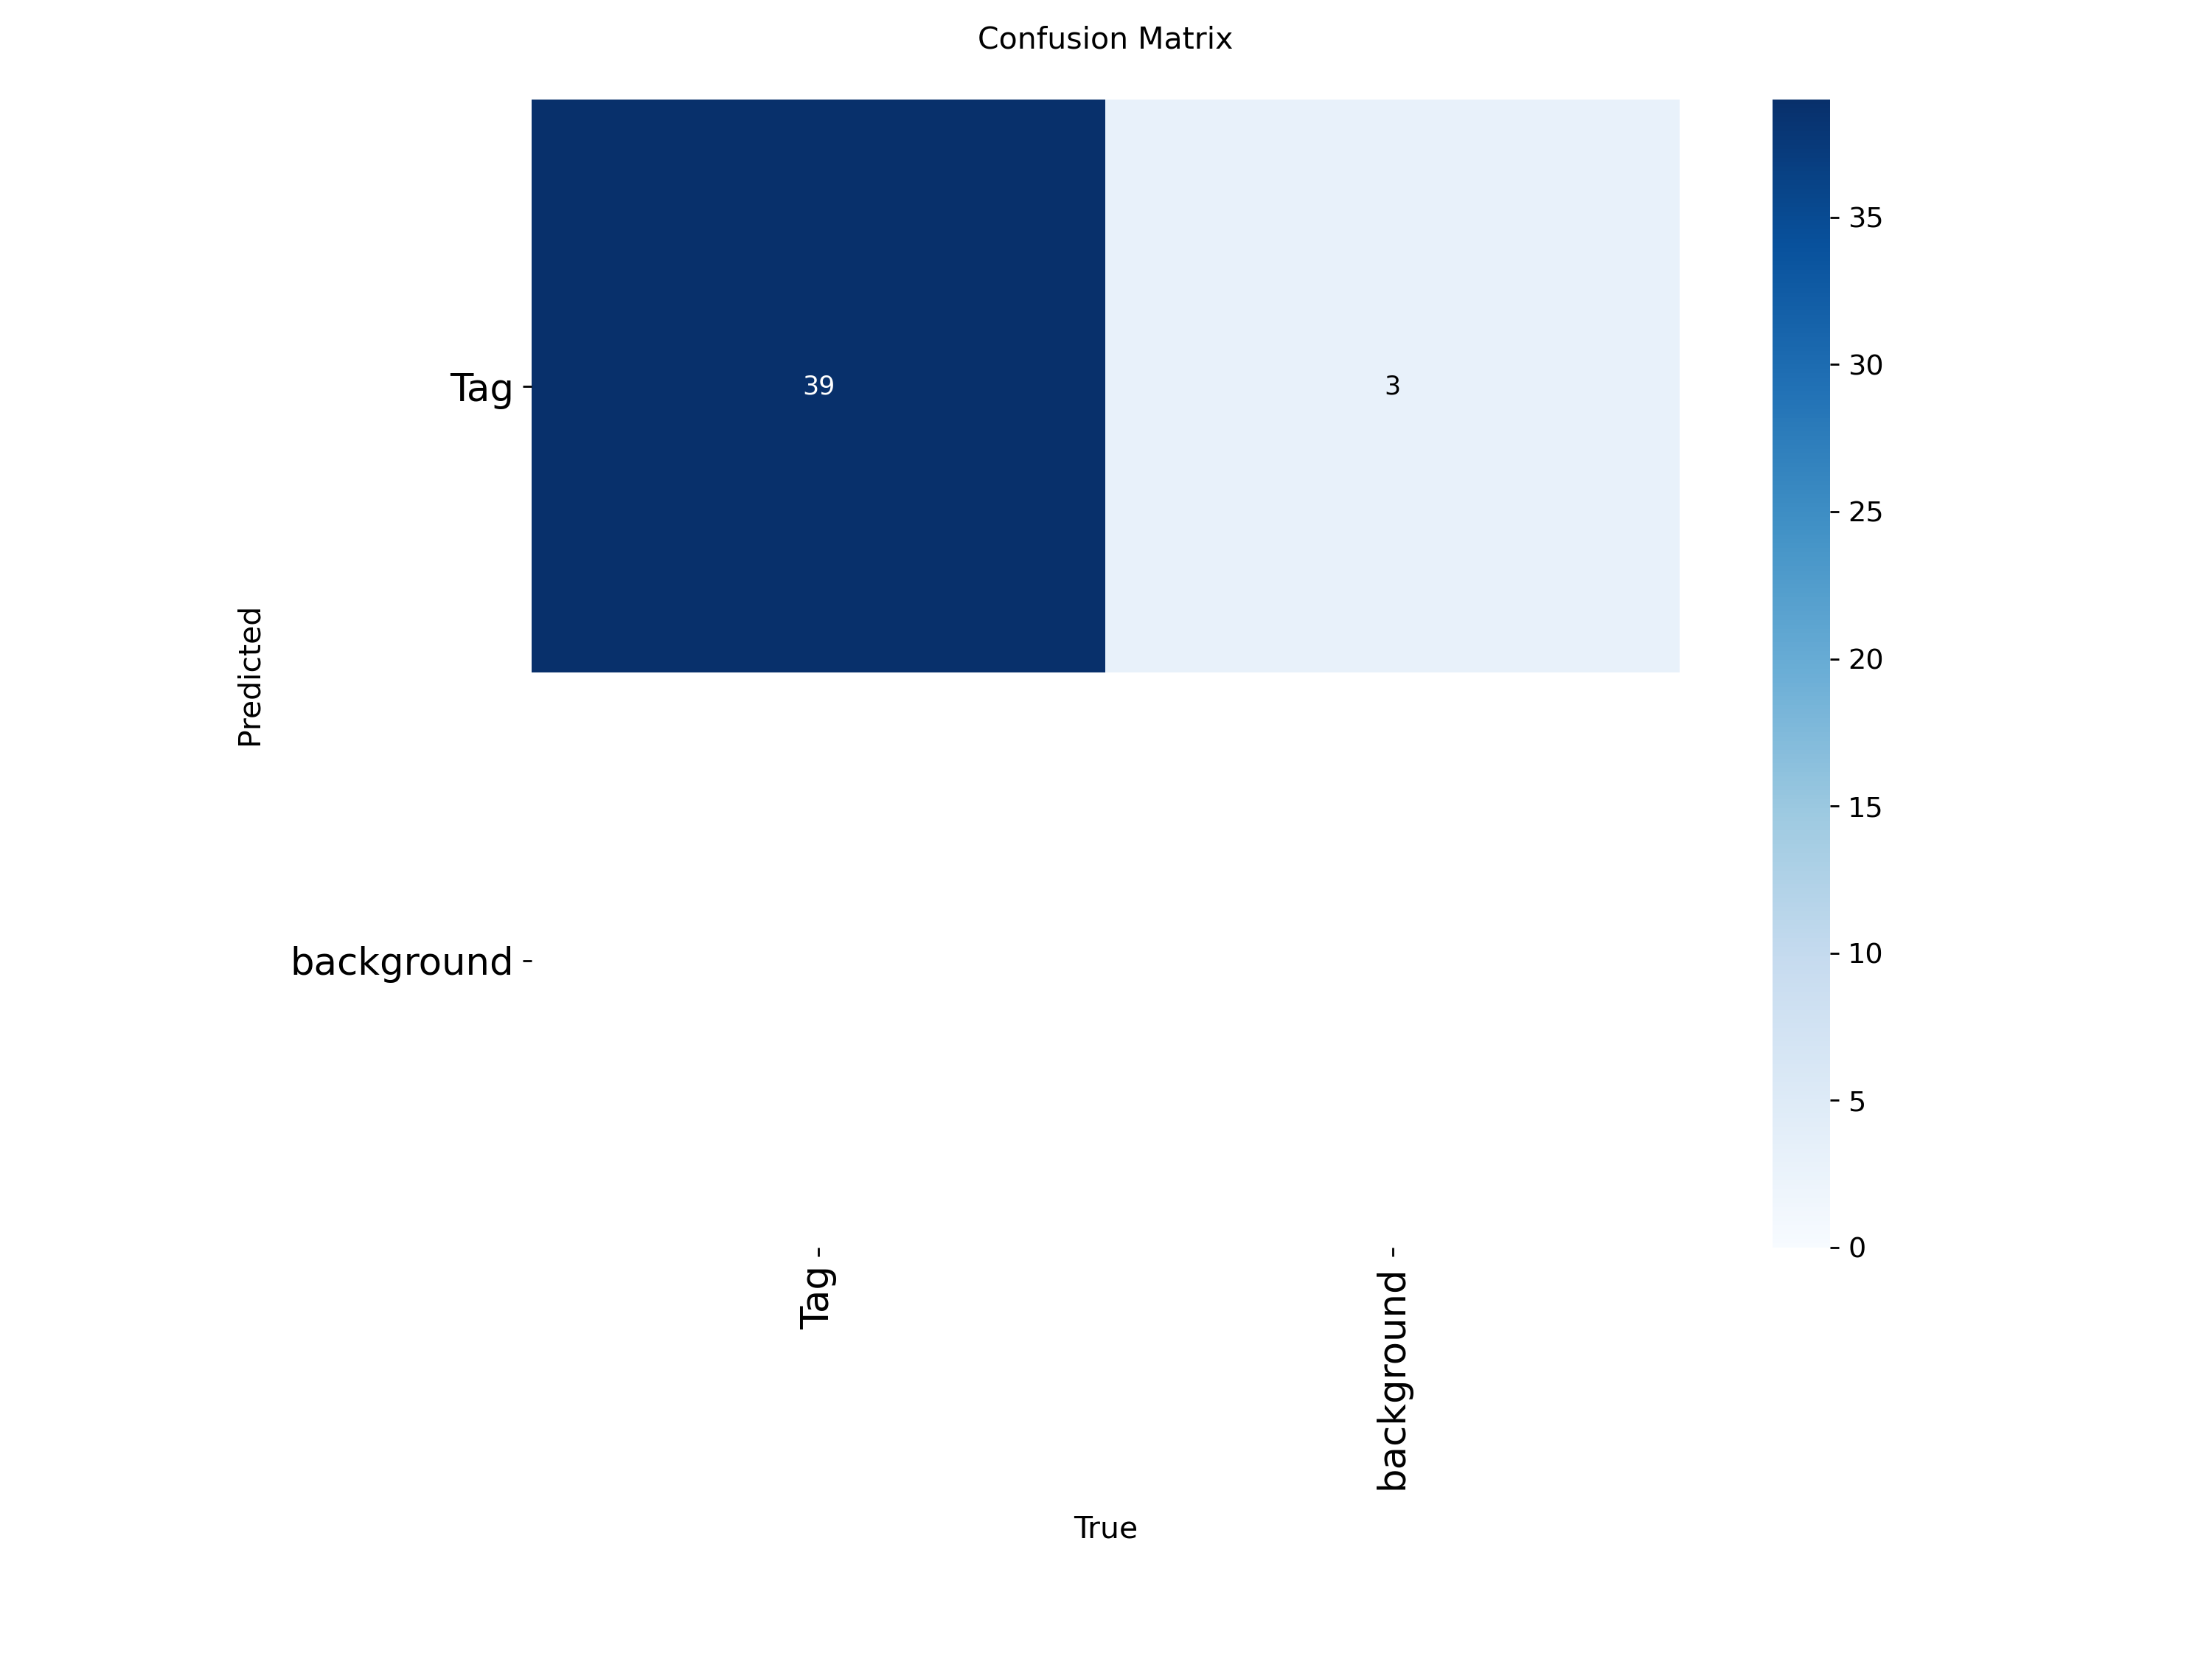

In [10]:
import glob
from IPython.display import Image, display

results_dir = metrics.save_dir  # folder where YOLO saved validation plots

conf_matrix = glob.glob(f"{results_dir}/confusion_matrix.png")

display(Image(filename=conf_matrix[0]))



Interpretation:

7 real cracks correctly detected as cracks ✅

0 cracks misclassified as mold ❌

5 molds correctly detected as mold ✅

0 molds misclassified as crack ❌

Background occasionally labeled as mold or crack (false positives).

Model loaded successfully!

image 1/21 /content/drive/MyDrive/CS440/Parking Tags/Dataset/test/images/1000003397_jpg.rf.9ab914b233732b5147d09300222ffe0c.jpg: 640x480 1 Tag, 49.5ms
image 2/21 /content/drive/MyDrive/CS440/Parking Tags/Dataset/test/images/1000003399_jpg.rf.0e2a6120b63a37b629bf111b18767881.jpg: 640x480 1 Tag, 8.5ms
image 3/21 /content/drive/MyDrive/CS440/Parking Tags/Dataset/test/images/1000003421_jpg.rf.06fd172970942b7c15a837c1283e75b4.jpg: 640x480 1 Tag, 9.0ms
image 4/21 /content/drive/MyDrive/CS440/Parking Tags/Dataset/test/images/1000003443_jpg.rf.e96cd5395c152ec0077c0406e32a1c6e.jpg: 640x480 1 Tag, 10.0ms
image 5/21 /content/drive/MyDrive/CS440/Parking Tags/Dataset/test/images/1000003445_jpg.rf.9843ec367462923c57a6bad634e3791b.jpg: 640x480 1 Tag, 8.7ms
image 6/21 /content/drive/MyDrive/CS440/Parking Tags/Dataset/test/images/1000003448_jpg.rf.a78d0d97f7e6ac13e5bcc5e46d4f813f.jpg: 640x480 1 Tag, 8.5ms
image 7/21 /content/drive/MyDrive/CS440/Parking Tags/Dataset/test/imag

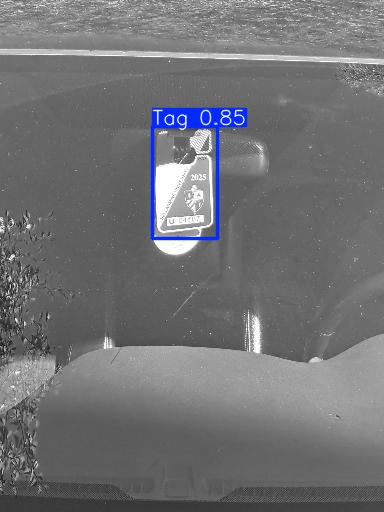

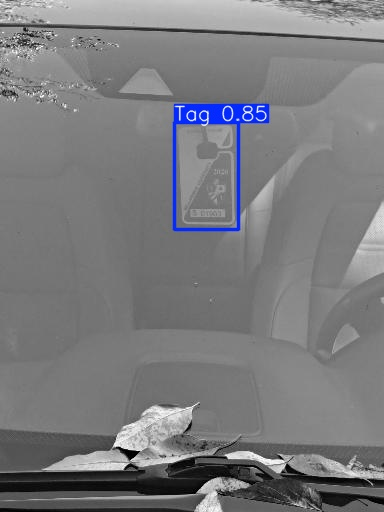

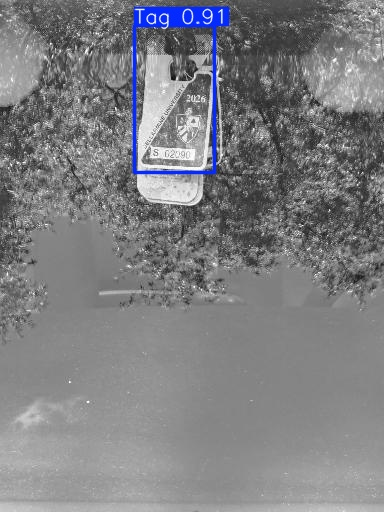

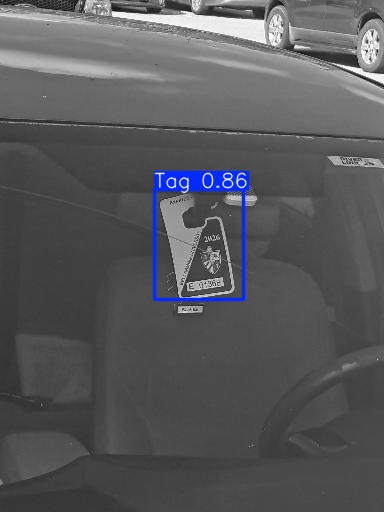

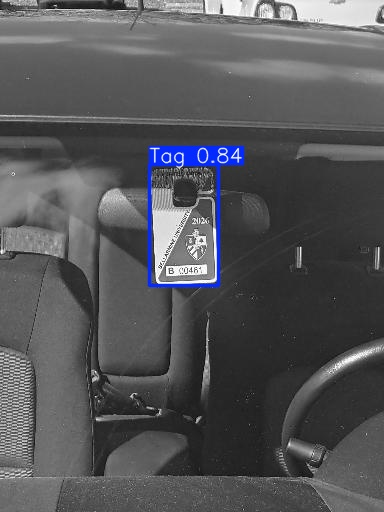

In [11]:

# YOLOv11 Model on Test Images
from ultralytics import YOLO
from IPython.display import Image, display
import os, glob

# --- Load trained model from your saved Drive location ---
MODEL_PATH = "/content/drive/MyDrive/CS440/Parking Tags/Dataset/weights/best.pt"
model = YOLO(MODEL_PATH)
print("Model loaded successfully!")

# --- Define your test or validation folder ----------------
# Use either validation images or a test folder
TEST_DIR = "/content/drive/MyDrive/CS440/Parking Tags/Dataset/test/images"

# Create output folder for predictions
OUTPUT_DIR = "/content/drive/MyDrive/CS440/Parking Tags/Dataset/test_predictions"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---  Run inference ---------------------------------------
# conf=0.25 means only predictions with >25% confidence are kept
results = model.predict(
    source=TEST_DIR,       # directory or single image
    conf=0.25,             # confidence threshold
    save=True,             # save predicted images
    save_txt=True,         # save YOLO labels with boxes
    project=OUTPUT_DIR,    # where to save
    name="results",        # subfolder name
    exist_ok=True
)

print("Predictions complete!")
print("Files saved in:", f"{OUTPUT_DIR}/results")

# --- Display a few prediction results --------------------
pred_images = glob.glob(f"{OUTPUT_DIR}/results/*.jpg")

print(f"Total test images predicted: {len(pred_images)}")
for img_path in pred_images[:5]:  # show first 5 images
    display(Image(filename=img_path))
